# Scalable RAG Data Ingestion and Pagination with Ray Data

In our previous tutorial, we outlined a standard pipeline for RAG document ingestion.

This tutorial dives into leveraging Ray for efficient processing, chunking, embedding, and storage of documents in a vector database, enabling fast embedding similarity searches.

With Ray’s ability to process large batches of files concurrently, it’s an ideal solution for managing high volumes of unstructured data at scale.

Here is the architecture diagram:

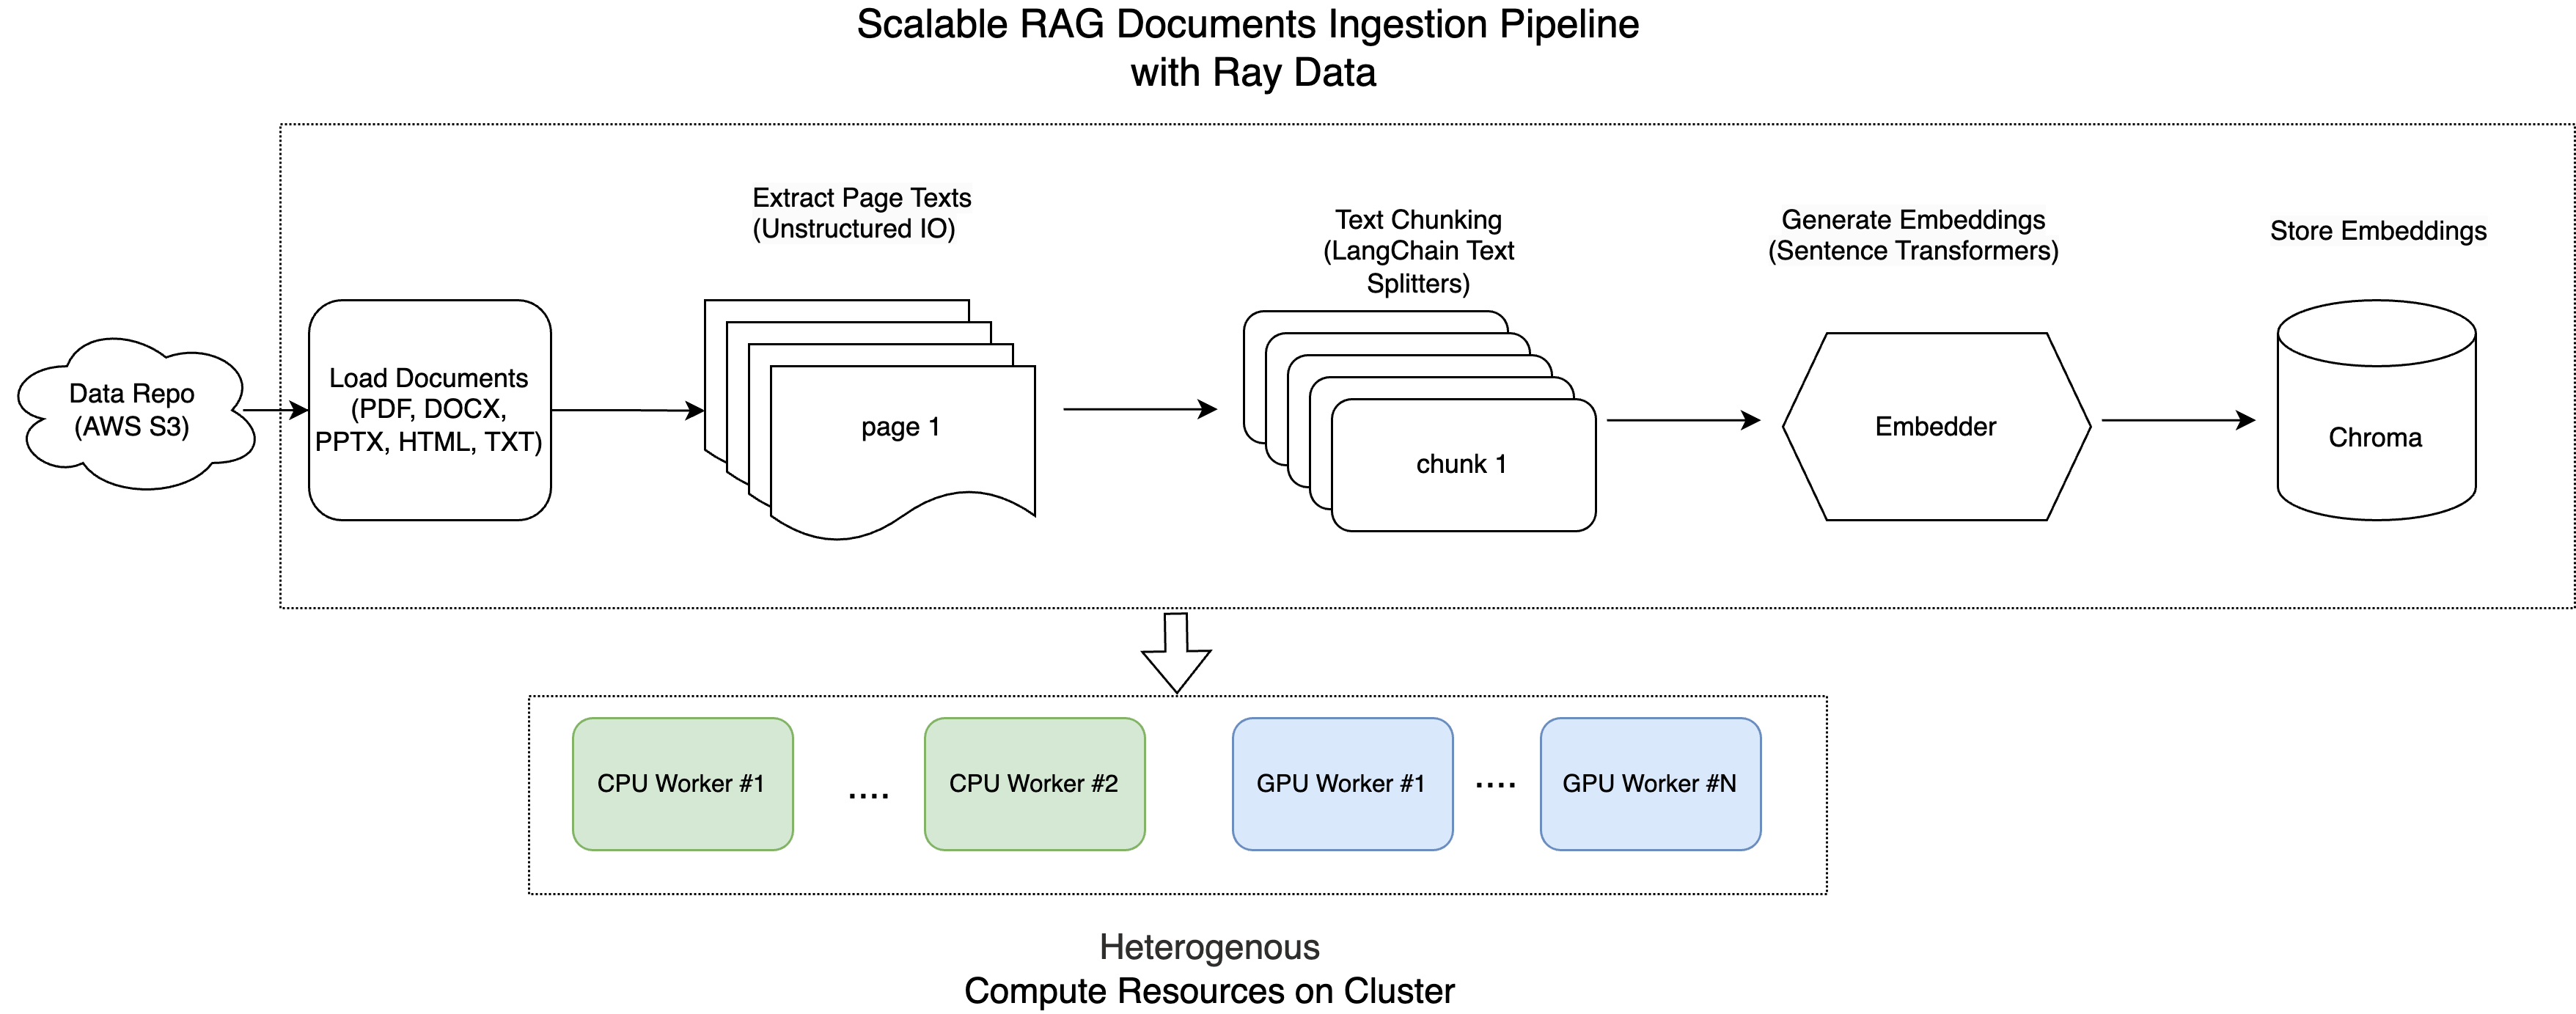



<div class="alert alert-block alert-warning">
  <b>Anyscale-Specific Configuration</b>
  
  <p>Note: This tutorial is optimized for the Anyscale platform. When running on open source Ray, additional configuration is required. For example, you’ll need to manually:</p>
  
  <ul>
    <li>
      <b>Configure your Ray Cluster:</b> Set up your multi-node environment (including head and worker nodes) and manage resource allocation (e.g., autoscaling, GPU/CPU assignments) without the Anyscale automation. See the Ray Cluster Setup documentation for details: <a href="https://docs.ray.io/en/latest/cluster/getting-started.html">https://docs.ray.io/en/latest/cluster/getting-started.html</a>.
    </li>
    <li>
      <b>Manage Dependencies:</b> Install and manage dependencies on each node since you won’t have Anyscale’s Docker-based dependency management. Refer to the Ray Installation Guide for instructions on installing and updating Ray in your environment: <a href="https://docs.ray.io/en/latest/ray-core/handling-dependencies.html">https://docs.ray.io/en/latest/ray-core/handling-dependencies.html</a>.
    </li>
    <li>
      <b>Set Up Storage:</b> Configure your own distributed or shared storage system (instead of relying on Anyscale’s integrated cluster storage). Check out the Ray Cluster Configuration guide for suggestions on setting up shared storage solutions: <a href="https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html">https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html</a>.
    </li>
  </ul>

</div>


## Loading Documents from S3

In this step, we retrieve 100 documents from the AWS S3 bucket. We utilize Ray Data, which simplifies the processing of large datasets efficiently.

We use the function `ray.data.read_binary_files` to read all files from the S3 bucket as raw binary data. 

Additionally, setting `include_paths=True` allows us to keep track of each file’s path (for example, your-bucket-name/folder/example.pdf), which will be useful in later steps.


In [1]:
import ray
import io
from pathlib import Path
from typing import Dict, List
from unstructured.partition.auto import partition
import chromadb
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import uuid
from langchain_text_splitters import (
    RecursiveCharacterTextSplitter,
    CharacterTextSplitter,
    NLTKTextSplitter,
)

SOURCE_DIRECTORY_S3="s3://anyscale-rag-application/100-docs/"
ds = ray.data.read_binary_files(SOURCE_DIRECTORY_S3, include_paths=True, concurrency=5)
ds.schema()

2025-04-28 14:02:42,918	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.0.41.124:6379...
2025-04-28 14:02:42,928	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at https://session-xl5p5c8v2puhejgj5rjjn1g6ht.i.anyscaleuserdata.com 
2025-04-28 14:02:42,942	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_72f4a5291407a334fea98932ca96e79412931b97.zip' (4.94MiB) to Ray cluster...
2025-04-28 14:02:42,961	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_72f4a5291407a334fea98932ca96e79412931b97.zip'.
2025-04-28 14:02:43,060	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-04-28_12-58-27_336835_47308/logs/ray-data
2025-04-28 14:02:43,061	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

Column  Type
------  ----
bytes   binary
path    string

## Scalable Document Processing and Pagination 

After retrieving the files from S3, the next step is to extract text from each page.

The S3 bucket contains **100** documents with more than **6000** pages, most of which are sample PDFs from this github repo: https://github.com/tpn/pdfs. These PDFs include both text-based and image-based formats. Additionally, there are five documents related to Anyscale jobs in various formats, including **PDF, PPTX, HTML, TXT, and DOCX**.

 **Note: Some documents are very large, containing more than 900 pages.**

We define a function that loads and partitions these documents using the **Unstructured** library for parsing. For more details, please refer to the Unstructured documentation: https://docs.unstructured.io/welcome

For image-based PDFs, the Unstructured lib uses the **Tesseract OCR engine** to process and extract text. 


Each document is read from a specified directory and processed page by page. The text from each page is grouped together with its corresponding metadata—such as the source file, file type, page number, and a unique document ID.

Below is the function that performs this task:

In [2]:

from pathlib import Path
import io
import uuid

def process_file(record: dict) -> dict:
    file_path = Path(record["path"])

    # Only process the following file extensions
    supported_extensions = {".pdf", ".docx", ".pptx", ".ppt", ".html", ".txt"}
    
    if file_path.suffix.lower() not in supported_extensions:
        # Not a supported file
        return {"pages": []}
    
    print(f"Processing file: {file_path}")
    
    try:
        with io.BytesIO(record["bytes"]) as stream:
            elements = partition(file=stream)  # This call may fail on some files
            
            # Generate a unique doc_id for this file
            doc_id = str(uuid.uuid4())

            # Group text by page
            page_texts = {}
            for el in elements:
                page_number = getattr(el.metadata, "page_number", 1) or 1
                if page_number not in page_texts:
                    page_texts[page_number] = []
                page_texts[page_number].append(str(el))

            # Combine text for each page
            pages = []
            for page_number, texts in page_texts.items():
                combined_text = " ".join(texts)
                pages.append({
                    "text": combined_text.strip(),
                    "source": str(file_path),
                    "page_number": page_number,
                    "doc_id": doc_id
                })

            return {"pages": pages}

    except Exception as e:
        # Handle files that cause errors during parsing
        print(f"Cannot process file {file_path}: {e}")
        return {"pages": []}


# Assuming `ds` is your dataset, apply the function
ds = ds.map(process_file, concurrency=8, num_cpus=1)
ds = ds.flat_map(lambda x: x["pages"])

print(ds)

2025-04-28 14:02:54,705	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2025-04-28_12-58-27_336835_47308/logs/ray-data
2025-04-28 14:02:54,706	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

FlatMap(<lambda>)
+- Map(process_file)
   +- Dataset(num_rows=?, schema={bytes: binary, path: string})


## Text Processing Pipeline 

This pipeline streamlines the conversion of raw text into structured embeddings:

* Chunking: Breaking text into smaller pieces.
* Embedding: Converting text chunks into numerical vectors.
* Storing: Saving vectors and metadata in Chroma DB.

To build the Text Processing Pipeline  using Ray Data, we define three classes `Chunker`, `Embedder`, and `ChromaWriter`. 

We then leverage Ray data operations such as `map` / `flat_map`, and `map_batches` to seamlessly integrate these steps.

For more details, check out: https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html. 


### The Chunker 
The `Chunker` class is responsible for splitting a document’s text into smaller chunks using one of several methods. Depending on the method specified (fixed or recursive), it uses the appropriate splitter from LangChain TextSplitter. Each chunk gets its own unique chunk_id, while preserving the original doc_id, page_number, etc.

In [3]:


class Chunker:
    def __init__(self, method: str = "recursive", chunk_size: int = 2048, chunk_overlap: int = 200):
        self.method = method
        if self.method == "fixed":
            splitter = CharacterTextSplitter(
                chunk_size=chunk_size, chunk_overlap=chunk_overlap ## here, the chunk size is number of chars, not tokens
            )
        elif self.method == "recursive":
            splitter = RecursiveCharacterTextSplitter(
                chunk_size=chunk_size, chunk_overlap=chunk_overlap ## here, the chunk size here is number of chars, not tokens
            )
        else:
            raise ValueError("Invalid chunking method")
        self.splitter = splitter

    def __call__(self, page: Dict) -> List[Dict]:
        chunks = []
        texts = self.splitter.split_text(page["text"])
        for chunk_index, text in enumerate(texts):
            chunks.append({
                "text": text,
                "source": page["source"],
                "page_number": page.get("page_number", 1),
                "chunk_id": str(uuid.uuid4()),
                "doc_id": page["doc_id"]  
            })
        return chunks


### The Embedder 
The Embedder uses a SentenceTransformer model to convert text chunks into numerical embeddings.

This class initializes a SentenceTransformer model (using CUDA if available) and defines a callable that takes a batch of text chunks, encodes them into embeddings, and returns a dictionary including both the embeddings and metadata.

In [4]:

class Embedder:
    def __init__(self, model_name: str = "intfloat/multilingual-e5-large-instruct"):
        self.model_name = model_name
        self.model = SentenceTransformer(
            self.model_name,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )

    def __call__(self, batch: Dict) -> Dict:
        # Generate embeddings for the batch of text chunks
        embeddings = self.model.encode(batch["text"], convert_to_numpy=True)

        return {
            "embeddings": embeddings,
            "text": batch["text"],
            "source": batch["source"],
            "doc_id": batch["doc_id"],
            "page_number": batch["page_number"],
            "chunk_id": batch["chunk_id"],
        }


### The ChromaWriter
The `ChromaWriter` is responsible for writing the embedded vectors along with metadata to a Chroma vector store. 

 We implement two special method ,  `__getstate__` and `__setstate__`, which are  special hooks in Python's pickling protocol :
* `__getstate__`: Prepares the object for pickling by removing attributes that can’t be serialized, ensuring that only the essential state is saved.
* `__setstate__`: Rebuilds the object after unpickling by restoring its state and reinitializing the unpickleable components so that the object remains fully functional.

These two functions will prevent the error such as `TypeError: cannot pickle 'weakref.ReferenceType' object` when you use `map_batches` during batching processing with Ray data. 

In [5]:

class ChromaWriter:
    def __init__(self, collection_name: str, chroma_path: str):
        self.collection_name = collection_name
        self.chroma_path = chroma_path
        self._init_chroma_client()

    def _init_chroma_client(self):
        self.chroma_client = chromadb.PersistentClient(path=self.chroma_path)
        self.collection = self.chroma_client.get_or_create_collection(
            name=self.collection_name,
            metadata={"hnsw:space": "cosine"}
        )

    def __getstate__(self):
        """
        Exclude the unpickleable chroma_client and collection from the state.
        """
        state = self.__dict__.copy()
        state.pop("chroma_client", None)
        state.pop("collection", None)
        return state

    def __setstate__(self, state):
        """
        Restore the state and reinitialize the chroma client and collection.
        """
        self.__dict__.update(state)
        self._init_chroma_client()

    def __call__(self, batch: dict) -> dict:
        """
        Process a batch of documents by adding them to the Chroma collection.
        """
        # Prepare metadata for each entry in the batch
        metadatas = []
        for i in range(len(batch["chunk_id"])):
            metadata = {
                "source": batch["source"][i],
                "doc_id": batch["doc_id"][i],
                "page_number": int(batch["page_number"][i]),
                "chunk_id": batch["chunk_id"][i]
            }
            metadatas.append(metadata)

        embeddings = batch["embeddings"].tolist()
        documents = [text for text in batch["text"]]
        ids = [id for id in batch["chunk_id"]]

        # Add the embeddings, documents, ids, and metadata to the collection
        self.collection.add(
            embeddings=embeddings,
            documents=documents,
            ids=ids,
            metadatas=metadatas
        )
        return {}




### Setting Up the Text Processing Pipeline

Finally, define constants for your data sources and vector store configuration. Then, build the Ray pipeline that:

* Chunks the text.
* Generates embeddings.
* Writes the results to Chroma DB.

In [6]:
# Constants for your data sources and vector store configuration
EMBEDDER_MODEL = "intfloat/multilingual-e5-large-instruct"
CHROMA_PATH = "/mnt/cluster_storage/vector_store"
CHROMA_COLLECTION_NAME = "anyscale_jobs_docs_embeddings"

# Build the processing pipeline using Ray Data API
processed_ds = (
    ds.flat_map(
        Chunker,
        fn_constructor_kwargs={"method": "recursive"},
        concurrency=5,
        num_cpus=1
    )
    .map_batches(
        Embedder,
        fn_constructor_kwargs={"model_name": EMBEDDER_MODEL},
        batch_size=800,
        concurrency=1,
        num_gpus=1
    )
    .map_batches(
        ChromaWriter,
        batch_size=500,
        concurrency=1,
        num_cpus=1,
        fn_constructor_kwargs={
            "collection_name": CHROMA_COLLECTION_NAME,
            "chroma_path": CHROMA_PATH
        }
    )
)


### Execute the Entire Text Processing Pipeline

Run the pipeline to process all documents:

In [ ]:
# Execute pipeline
processed_ds.take_all()
print("Data ingestion completed successfully!")

## Verifying and Searching the Data

### Check Stored Embeddings
After processing, you can verify how many vectors have been stored in the Chroma DB:

In [8]:

import chromadb
CHROMA_PATH = "/mnt/cluster_storage/vector_store"
CHROMA_COLLECTION_NAME = "anyscale_jobs_docs_embeddings"

# Initialize the Chroma client and retrieve (or create) your collection
chroma_client = chromadb.PersistentClient(path=CHROMA_PATH)
collection = chroma_client.get_or_create_collection(name=CHROMA_COLLECTION_NAME)

# Show how many vectors are stored in the collection.
vector_count = collection.count()
print("Total number of vectors in the collection:", vector_count)

Total number of vectors in the collection: 9504


You can also check the storage usage:

In [9]:
!ls -lh /mnt/cluster_storage/vector_store

total 106M
drwxr-xr-x 2 ray users 6.0K Apr 28 14:06 05e4ca13-4b3c-4db8-a68e-945320c94ef8
-rw-r--r-- 1 ray users 106M Apr 28 14:15 chroma.sqlite3


### Performing a Vector Search

Now that the data is ingested, you can search for relevant document chunks. For example, to search for “how to submit anyscale jobs”:



In [10]:
from pprint import pprint


query_text = "how to submit anyscale jobs"

# Re-use the Embedder to generate the query embedding
embedder = Embedder()  # re-uses the same SentenceTransformer internally
query_batch = {"text": [query_text], "source": [""],"doc_id": [""], 
"page_number": [""], "chunk_id": [""]}


query_result = embedder(query_batch)
# Since we passed a single query, extract the first embedding
query_embedding = query_result["embeddings"][0].tolist()

print("query_embedding is:", query_embedding)

# Query the collection for the top 3 most similar documents.
results = collection.query(
    query_embeddings=query_embedding,
    n_results=3,
    include=["documents", "metadatas", "distances"]
)

print("Query Results:")
pprint(results)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/140k [00:00<?, ?B/s]

sentence_xlm-roberta_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

query_embedding is: [-0.0017044333508238196, 0.015340730547904968, 0.0016255583614110947, -0.030604546889662743, 0.011112975887954235, 0.006347003858536482, -0.01323129516094923, 0.04068616405129433, 0.03265380859375, -0.0014982214197516441, 0.03976968303322792, 0.03652549162507057, -0.017817512154579163, -0.0057686143554747105, -0.010639476589858532, 0.0015948776854202151, -0.0434483140707016, 0.027622589841485023, -0.013817636296153069, -0.024267688393592834, 0.04740871116518974, 0.006913214456290007, -0.02894500270485878, -0.050302654504776, -0.017056522890925407, -0.028964614495635033, -0.012868545949459076, -0.03471929952502251, -0.019390804693102837, -0.038162391632795334, -0.03007868491113186, 0.016964182257652283, -0.018217697739601135, -0.026014285162091255, -0.033512428402900696, 0.031858157366514206, 0.018111934885382652, 0.032804250717163086, -0.03364420682191849, 0.05894007906317711, -0.027891116216778755, 0.027099130675196648, 0.017965391278266907, -0.01843736693263054, -

### Reformatting the Search Results 

The previous query results from Chroma were difficult to read. Here, we refine the formatting to enhance readability and make the results more user-friendly.

In [11]:
from pprint import pprint
def reformat(chroma_results: dict) -> list:
    """
    Reformat chroma db results to a list of search items containing:
    - chunk_id
    - chunk_index
    - doc_id
    - page_number
    - source
    - text (from documents)
    - distance
    - score

    Parameters:
        chroma_results (dict): The raw results from the Chroma DB query.

    Returns:
        list: A list of dictionaries with the desired keys.
    """
    reformatted = []
    
    # Get the lists from the results. They are expected to be lists of lists.
    metadatas = chroma_results.get("metadatas", [])
    documents = chroma_results.get("documents", [])
    distances = chroma_results.get("distances", [])
    
    # Loop over each group (each inner list represents one set of matches)
    chunk_index = 1
    for meta_group, doc_group, distance_group in zip(metadatas, documents, distances):
        # Iterate over each item in the inner lists
        for meta, text, distance in zip(meta_group, doc_group, distance_group):
            item = {
                "chunk_index": chunk_index,
                "chunk_id": meta.get("chunk_id"),
                "doc_id": meta.get("doc_id"),
                "page_number": meta.get("page_number"),
                "source": meta.get("source"),
                "text": text,
                "distance": distance,
                "score": 1 - distance
            }
            reformatted.append(item)
            chunk_index += 1
    
    return reformatted


print("refromat Results:")
pprint(reformat(results))

refromat Results:
[{'chunk_id': 'd313cd7a-2835-49e4-80de-666a3e2f98df',
  'chunk_index': 1,
  'distance': 0.18700510263442993,
  'doc_id': 'b62b2ee6-f4f8-4d1c-a63f-4dc7415f9f69',
  'page_number': 1,
  'score': 0.8129948973655701,
  'source': 'anyscale-rag-application/100-docs/Job_schedules.html',
  'text': 'Create and manage jobs Submitting a job\u200b To submit your job to '
          'Anyscale, use the Python SDK or CLI and pass in any additional '
          'options or configurations for the job. By default, Anyscale uses '
          'your workspace or cloud to provision a cluster to run your job. You '
          'can define a custom cluster through a compute config or specify an '
          'existing cluster. Once submitted, Anyscale runs the job as '
          'specified in the entrypoint command, which is typically a Ray Job. '
          "If the run doesn't succeed, the job restarts using the same "
          'entrypoint up to the number of max_retries. CLI Python SDK anyscale '


(autoscaler +16m48s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +16m48s) [autoscaler] [4xA10G:48CPU-192GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +16m53s) [autoscaler] [4xA10G:48CPU-192GB] Launched 1 instances.
(autoscaler +17m53s) [autoscaler] Cluster upscaled to {60 CPU, 5 GPU}.
(autoscaler +21m33s) [autoscaler] Downscaling node i-0cb70f496c5966174 (node IP: 10.0.53.5) due to node idle termination.
(autoscaler +21m33s) [autoscaler] Cluster resized to {12 CPU, 1 GPU}.
(autoscaler +21m38s) [autoscaler] Cluster upscaled to {60 CPU, 5 GPU}.
(autoscaler +34m3s) [autoscaler] Downscaling node i-0cb70f496c5966174 (node IP: 10.0.53.5) due to node idle termination.
(autoscaler +34m3s) [autoscaler] Cluster resized to {12 CPU, 1 GPU}.
(autoscaler +37m8s) [autoscaler] [4xA10G:48CPU-192GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +37m13s) 

## Observations

The text chunks retrieved via vector search align well with the user's query, “how to submit Anyscale jobs?”. Additionally, the top three chunks display relatively high similarity scores. This is impressive given that we have ingested 100 documents—more than 6,000 pages—most of which are irrelevant. Despite the large volume of content, the system still successfully retrieved relevant information.

## Summary

Using Ray Data, you can ingest and process large volumes of documents in parallel. This tutorial demonstrated how to:

* Retrieve documents from S3
* Extract and partition text with Ray
* Convert text into embeddings and store them in a vector database
* Perform fast similarity searches on your document data


This scalable pipeline is ideal for managing unstructured data and enabling rapid, accurate document retrieval.